# MapReduce using SPARK

In [83]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

Populating the interactive namespace from numpy and matplotlib


# Spark Context

I was not able to perform the following two imports. Instead, I created a spark context with the following cell.

In [15]:
#import findspark
#findspark.init()
#import pyspark
#sc = pyspark.SparkContext()

In [2]:
sc = SparkContext.getOrCreate()

In [3]:
sc

<SparkContext master=local[2] appName=PySparkShell>

In [4]:
sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).map(lambda x: x**2).sum()

385

### Create a RDD

In [6]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
# Print out the type of wordsRDD
print(type(wordsRDD))

<class 'pyspark.rdd.RDD'>


### Call `collect` on an RDD: Lazy Spark

In [7]:
wordsRDD.collect()

['cat', 'elephant', 'rat', 'rat', 'cat']

### Word Examples

In [8]:
def makePlural(word):
    return word + 's'

print(makePlural('cat'))

cats


Transform one RDD into another.

In [11]:
pluralRDD = wordsRDD.map(makePlural)
print(pluralRDD.first())
print(pluralRDD.take(2))

cats
['cats', 'elephants']


In [16]:
pluralRDD.take(1)

['cats']

In [17]:
pluralRDD.collect()

['cats', 'elephants', 'rats', 'rats', 'cats']

### Key Value Pairs

In [19]:
wordPairs = wordsRDD.map(lambda w: (w, 1))
print(wordPairs.collect())

[('cat', 1), ('elephant', 1), ('rat', 1), ('rat', 1), ('cat', 1)]


### WORD COUNT!

In [20]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
wordCountsCollected = (wordsRDD
                       .map(lambda w: (w, 1))
                       .reduceByKey(lambda x,y: x+y)
                       .collect())
print(wordCountsCollected)

[('cat', 2), ('elephant', 1), ('rat', 2)]


In [22]:
print((wordsRDD
    .map(lambda w: (w, 1))
    .reduceByKey(lambda x,y: x+y)).toDebugString())

b'(4) PythonRDD[24] at RDD at PythonRDD.scala:48 []\n |  MapPartitionsRDD[23] at mapPartitions at PythonRDD.scala:427 []\n |  ShuffledRDD[22] at partitionBy at NativeMethodAccessorImpl.java:0 []\n +-(4) PairwiseRDD[21] at reduceByKey at <ipython-input-22-a46b488739a0>:3 []\n    |  PythonRDD[20] at reduceByKey at <ipython-input-22-a46b488739a0>:3 []\n    |  ParallelCollectionRDD[9] at parallelize at PythonRDD.scala:480 []'


### Using Cache

In [24]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
print(wordsRDD)
wordsRDD.count()

ParallelCollectionRDD[25] at parallelize at PythonRDD.scala:480


5

Normally, every operation is run from the start. This may be inefficient in many cases. So when appropriate, we may want to cache the result the first time an operation is run on an RDD.

In [25]:
#this is rerun from the start
wordsRDD.count()

5

In [26]:
#default storage level (MEMORY_ONLY)
wordsRDD.cache()#nothing done this is still lazy

ParallelCollectionRDD[25] at parallelize at PythonRDD.scala:480

In [27]:
#parallelize is rerun and cached because we told it to cache
wordsRDD.count()

5

In [28]:
#this `sc.parallelize` is not rerun in this case
wordsRDD.count()

5

Where is this useful: it is when you have branching parts or loops, so that you dont do things again and again. Spark, being "lazy" will rerun the chain again. So cache or persist serves as a checkpoint, breaking the RDD chain or the lineage.

In [29]:
birdsList=['heron','owl']
animList=wordsList+birdsList
animaldict={}
for e in wordsList:
    animaldict[e]='mammal'
for e in birdsList:
    animaldict[e]='bird'
animaldict

{'cat': 'mammal',
 'elephant': 'mammal',
 'heron': 'bird',
 'owl': 'bird',
 'rat': 'mammal'}

In [30]:
animsrdd = sc.parallelize(animList, 4)
animsrdd.cache()
#below runs the whole chain but causes cache to be populated
mammalcount=animsrdd.filter(lambda w: animaldict[w]=='mammal').count()
#now only the filter is carried out
birdcount=animsrdd.filter(lambda w: animaldict[w]=='bird').count()
print(mammalcount, birdcount)

5 2


### Exercises: Fun with MapReduce
Read http://spark.apache.org/docs/latest/programming-guide.html for some useful background and then try out the following exercises

The file `./sparklect/english.stop.txt` contains a list of English stopwords, while the file `./sparklect/shakes/juliuscaesar.txt` contains the entire text of Shakespeare's 'Julius Caesar'.

* Load all of the stopwords into a Python list
* Load the text of Julius Caesar into an RDD using the `sparkcontext.textfile()` method. Call it `juliusrdd`.

In [57]:
# your turn
import re
# creating a set makes the searching faster
stop_words = set(open('.\sparklect\english.stop.txt','r').read().split())
juliusrdd = sc.textFile('.\sparklect\shakes\juliuscaesar.txt')

How many words does Julius Caesar have? *Hint: use `flatMap()`*.

In [58]:
# your turn
jc_words = juliusrdd.flatMap(lambda line: re.split('\W+', line.lower().strip()))
# remove nulls
jc_words = jc_words.filter(lambda x: len(x) > 0) 
print('number of words in Julius Caesar: %s' % jc_words.count())

number of words in Julius Caesar: 21572


Now print the first 20 words of Julius Caesar as a Python list.

In [59]:
# your turn
jc_words.take(20)

['1599',
 'the',
 'tragedy',
 'of',
 'julius',
 'caesar',
 'by',
 'william',
 'shakespeare',
 'dramatis',
 'personae',
 'julius',
 'caesar',
 'roman',
 'statesman',
 'and',
 'general',
 'octavius',
 'triumvir',
 'after']

Now print the first 20 words of Julius Caesar, **after removing all the stopwords**. *Hint: use `filter()`*.

In [60]:
# your turn
jc_words = jc_words.filter(lambda x: x not in stop_words)
jc_words.take(20)

['1599',
 'tragedy',
 'julius',
 'caesar',
 'william',
 'shakespeare',
 'dramatis',
 'personae',
 'julius',
 'caesar',
 'roman',
 'statesman',
 'general',
 'octavius',
 'triumvir',
 'caesar',
 'death',
 'augustus',
 'caesar',
 'emperor']

Now, use the word counting MapReduce code you've seen before. Count the number of times each word occurs and print the top 20 results as a list of tuples of the form `(word, count)`. *Hint: use `takeOrdered()` instead of `take()`*

In [63]:
# your turn
jc_counts = jc_words.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)
jc_counts.takeOrdered(20)

[('1', 5),
 ('1599', 1),
 ('1990', 5),
 ('1993', 5),
 ('2', 5),
 ('abide', 2),
 ('abler', 1),
 ('abridged', 1),
 ('abroad', 2),
 ('absence', 1),
 ('absent', 1),
 ('abuse', 2),
 ('accents', 1),
 ('accidental', 1),
 ('accoutred', 1),
 ('acquainted', 1),
 ('act', 7),
 ('acted', 1),
 ('acting', 1),
 ('action', 2)]

Plot a bar graph. For each of the top 20 words on the X axis, represent the count on the Y axis.

In [71]:
# your turn
# switch from (word, count) to (count, word) and sort descending
jc_counts = jc_counts.map(lambda x: (x[1], x[0])).sortByKey(False)
top_20 = jc_counts.take(20)
top_20

[(366, 'brutus'),
 (279, 'caesar'),
 (227, 'cassius'),
 (129, 'antony'),
 (116, 'thou'),
 (73, 'casca'),
 (71, 'good'),
 (69, 'citizen'),
 (66, 'men'),
 (59, 'lucius'),
 (59, 'man'),
 (57, 'enter'),
 (54, 'thy'),
 (54, 'thee'),
 (47, 'messala'),
 (44, 'lord'),
 (43, 'octavius'),
 (43, 'rome'),
 (41, 'speak'),
 (40, 'cinna')]

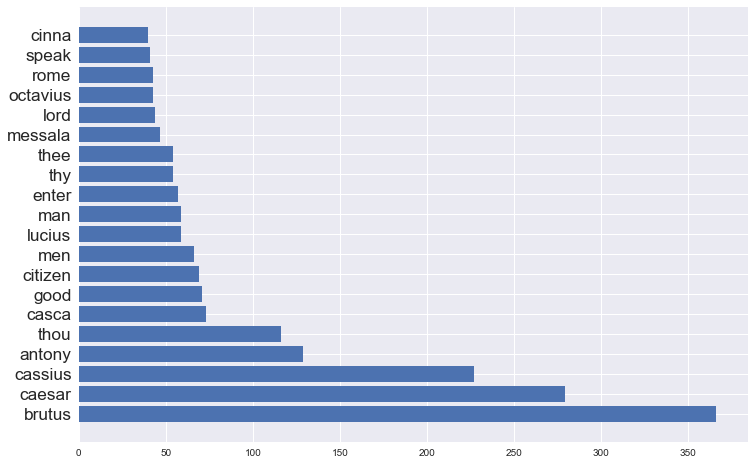

In [88]:
# plot fits better with words on y-axis
words = [w[1] for w in top_20]
score = [s[0] for s in top_20]
x_pos = range(len(words))

plt.barh(x_pos, score)
plt.yticks(x_pos, words, size='xx-large')
plt.show()

### Using partitions for parallelization

In order to make your code more efficient, you want to use all of the available processing power, even on a single laptop. If your machine has multiple cores, you can tune the number of partitions to use all of them! From http://www.stat.berkeley.edu/scf/paciorek-spark-2014.html:

>You want each partition to be able to fit in the memory availalbe on a node, and if you have multi-core nodes, you want that as many partitions as there are cores be able to fit in memory.

>For load-balancing you'll want at least as many partitions as total computational cores in your cluster and probably rather more partitions. The Spark documentation suggests 2-4 partitions (which they also seem to call slices) per CPU. Often there are 100-10,000 partitions. Another rule of thumb is that tasks should take at least 100 ms. If less than that, you may want to repartition to have fewer partitions.

In [89]:
shakesrdd=sc.textFile(".\sparklect\shakes\*.txt", minPartitions=4)

In [90]:
shakesrdd.take(10)

['1601',
 'AS YOU LIKE IT',
 '',
 'by William Shakespeare',
 '',
 '',
 '',
 'DRAMATIS PERSONAE.',
 '',
 '']

Now calculate the top 20 words in all of the files that you just read.

In [91]:
# your turn
shakes_words = shakesrdd.flatMap(lambda line: re.split('\W+', line.lower().strip()))
# remove nulls
shakes_words = shakes_words.filter(lambda x: len(x) > 0)
# remove stopwords
shakes_words = shakes_words.filter(lambda x: x not in stop_words)

shakes_counts = shakes_words.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)

# switch from (word, count) to (count, word) and sort descending
shakes_counts = shakes_counts.map(lambda x: (x[1], x[0])).sortByKey(False)
shakes_counts.take(20)

[(2177, 'thou'),
 (1549, 'thy'),
 (1336, 'sir'),
 (1266, 'thee'),
 (1230, 'good'),
 (1128, 'lord'),
 (1027, 'enter'),
 (998, 'love'),
 (968, 'll'),
 (878, 'man'),
 (793, 'hath'),
 (655, 'make'),
 (620, 'king'),
 (615, 'tis'),
 (599, 'duke'),
 (584, 'give'),
 (557, 'speak'),
 (495, 'father'),
 (491, 'time'),
 (478, 'brutus')]

In [92]:
sc.stop()